In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp
import scipy as sc

import lbg_forecast.priors_gp_dust as gpdp

In [2]:
ngal = 20000
n, tau, tau1, ne, taue, tau1e, sfr = gpdp.get_nagaraj22_samples(ngal)

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
M

In [3]:
nsamples = 500000
recent_sfrs, dust2, dust_index, dust1 = gpdp.get_pop_cosmos_samples(nsamples)

<ErrorbarContainer object of 3 artists>

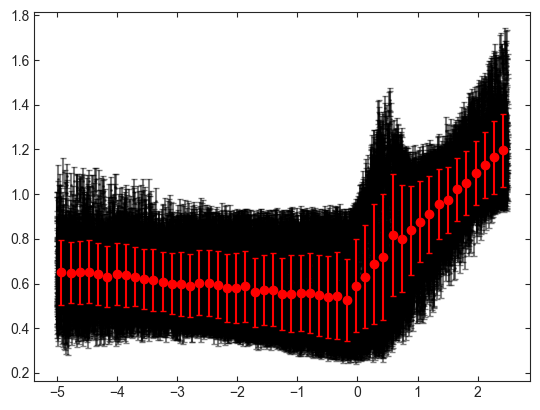

In [4]:
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(sfr, tau, -5, 2.5, 50)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

<ErrorbarContainer object of 3 artists>

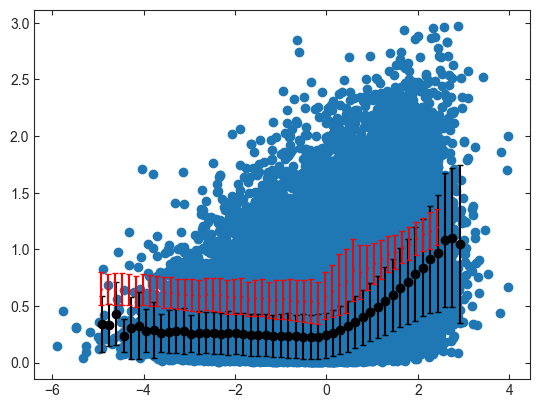

In [5]:
plt.scatter(recent_sfrs, dust2)
bin_centers, bin_means, bin_std = gpdp.process_samples(recent_sfrs, dust2, -5, 3, 50)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [6]:
train_sfrs, train_dust2, train_dust2_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust2, -4, 2.5, 25)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

In [7]:
#plt.scatter(bin_centers_de, avg_err, c='k')
#a, b, berr = gpdp.process_samples(train_sfrs, train_dust2_errs, -4, 2.5, 40)
#a, b, berr = gpdp.training_data_to_torch(x0, y0, y0err, x, y, yerr)
#plt.errorbar(a, b, berr)
#train_a, train_b, train_berr = torch.from_numpy(a), torch.from_numpy(b), torch.from_numpy(berr)

947.335197600002
924.9071868329237
901.6591246440682
877.6272843154298
852.8550905219032
827.3930953990541
801.2988184170772
774.636443705057
747.4763741866851
719.8946477865995
691.9722264926355
663.7941740980438
635.4487429451291
607.0263936407032
578.6187740678477
550.3176847956476
522.2140571627564
494.39696803944463
466.9527119814646
439.96394782524874
413.5089331618773
387.6608565543518
362.4872737389294
338.04965050296397
314.4030117025016
291.5956931598042
269.66919104798285
248.65810183132587
228.59014483758173
209.48625901404301
191.3607652771305
174.22158603518753
158.07051390607472
142.90352234777393
128.71111184462728
115.47868635895237
103.18695578939362
91.81236091121451
81.32751743147372
71.70167519649532
62.901187294827054
54.88998216914373
47.630030501043045
41.08179820993968
35.20467778123341
29.957392190115733
25.298368342200927
21.186079456841643
17.579357576878454
14.43767816378442
11.721418649488644
9.392092192654253
7.412557088654466
5.747201587132078
4.36210343

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


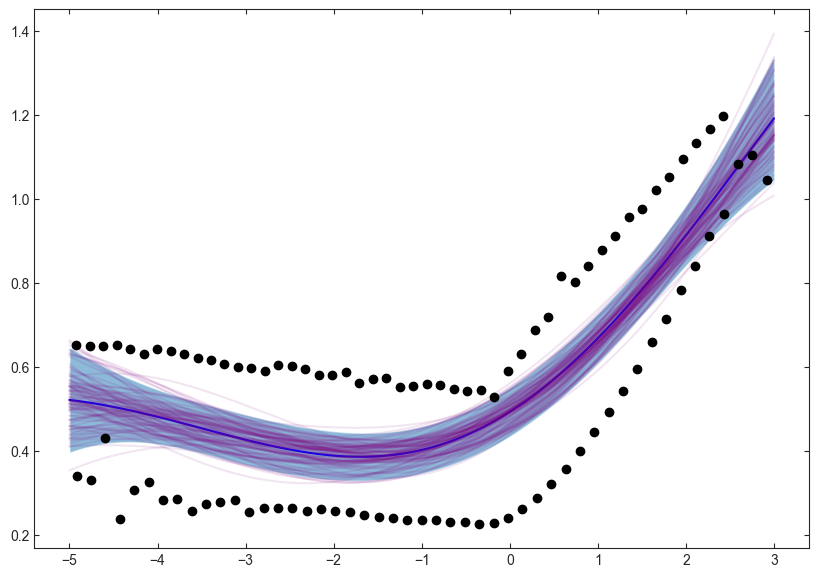

In [8]:
#train_sfrs, train_dust2, train_dust2_errs = torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(yerr)
test_sfrs = torch.linspace(-5, 3, 100)
trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_sfrs, train_dust2, [5.0, 15.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds_mu, test_sfrs, train_sfrs, train_dust2, train_dust2_errs*0, labelx="", labely="", alpha=0.5)

for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds_mu.sample().numpy(), c='purple', alpha=0.1)

In [9]:
#mean = np.interp(test_sfrs, train_sfrs, train_dust2)
#with torch.no_grad():
#    for i in range(500):
#        plt.plot(test_sfrs, f_preds_mu.sample().numpy()+mean, c='purple', alpha=0.1)
#    plt.plot(test_sfrs, mean, c='b')
#    lower, upper = f_preds_mu.confidence_region()
#    plt.fill_between(test_sfrs, lower+mean, upper+mean, alpha=0.2)

In [10]:
#test_sfrs = torch.linspace(-4, 3, 100)
#trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model(torch.from_numpy(bin_centers_de), torch.from_numpy(avg_err), torch.from_numpy(avg_err*0), [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
#f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
#gpdp.gp_plot_confidence_obs(f_preds_sig, test_sfrs, torch.from_numpy(bin_centers_de), torch.from_numpy(avg_err), torch.from_numpy(avg_err*0), labelx="", labely="", alpha=0.5)

#for param_name, param in trained_model_sig.named_parameters():
#    print(f'Parameter name: {param_name:42} value = {param.item()}')

#with torch.no_grad():
#    for i in range(500):
#        plt.plot(test_sfrs, f_preds_sig.sample().numpy(), c='purple', alpha=0.1)

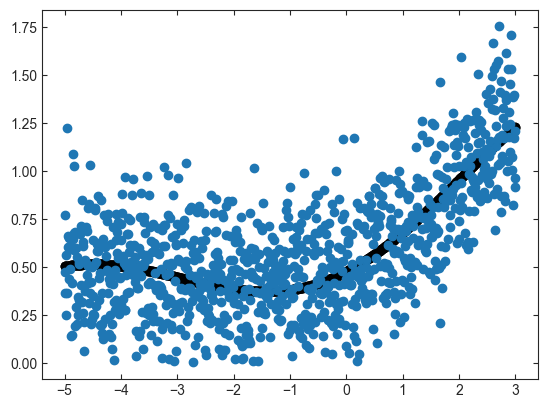

In [11]:
test_sfrs = torch.from_numpy(np.linspace(-5, 3, 1000))
#mean = np.interp(test_sfrs, train_sfrs, train_dust2)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
#f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
mean_dust2 = f_preds_mu.sample().numpy()#+mean
#mean_dust2 = np.where(test_sfrs<-1, np.interp(-1, test_sfrs, mean_dust2), mean_dust2)
#sig_dust2 = f_preds_sig.sample().numpy()
#sig_dust2 = np.where(sig_dust2>0.4, 0.4, sig_dust2)
#sig_dust2 = np.where(test_sfrs<-1, 0.2, sig_dust2)
scatter = np.random.uniform(0.1, 0.3)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, scatter, 0.0, 4.0, len(test_sfrs)))

In [12]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')

<ErrorbarContainer object of 3 artists>

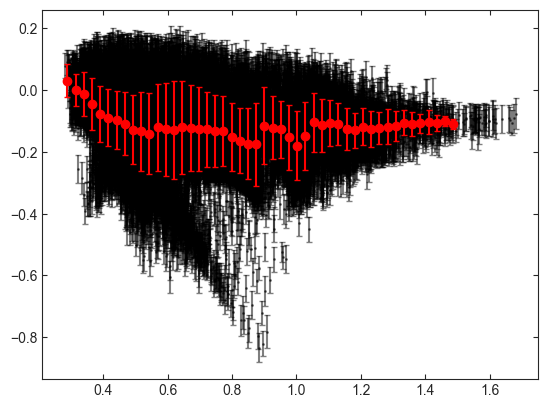

In [13]:
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, n, 0.25, 1.5, 50)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

<ErrorbarContainer object of 3 artists>

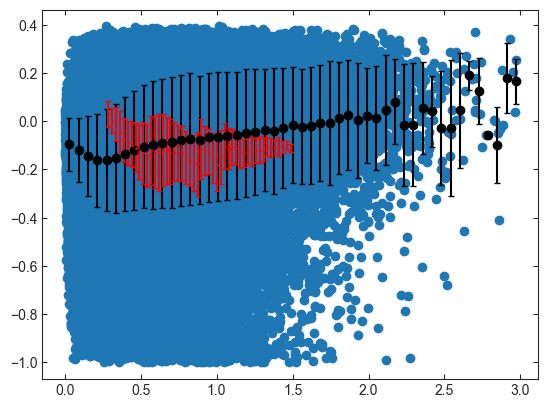

In [14]:
plt.scatter(dust2, dust_index)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust_index, 0.0, 3.0, 50)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [15]:
train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust_index, 0.0, 3.0, 50)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

88.91625115229321
82.10820589777002
75.25965569003357
68.41466562894298
61.621411033799994
54.93173264802544
48.4004967666496
42.08473908408903
36.0425741303648
30.33185718113825
25.00859286703018
20.125095577074575
15.7279231713139
11.855629969249367
8.536419905964205
5.78582762356779
3.6046128811286753
1.977115575680284
0.8703705170368092
0.23429960068093228
0.003255340430101214
-0.044816906684257585
-0.09297694492367592
-0.14123766039274624
-0.18955770493291513
-0.23789319181308746
-0.28619775882174825
-0.334422556957927
-0.38251617895989287
-0.43042453982789936
-0.47809072033907013
-0.5254547840545092
-0.572453578321989
-0.619020530170417
-0.6650854486803257
-0.7105743463038765
-0.7554092925960396
-0.7995083147947006
-0.8427853605406286
-0.8851503386701969
-0.9265092544151274
-0.9667644555829933
-1.0058150066053644
-1.0435572081451818
-1.0798852818126903
-1.1146922430110726
-1.1478709903042843
-1.17931564660355
-1.208923194516779
-1.236595452799959
-1.2622414393515389
-1.2857801544

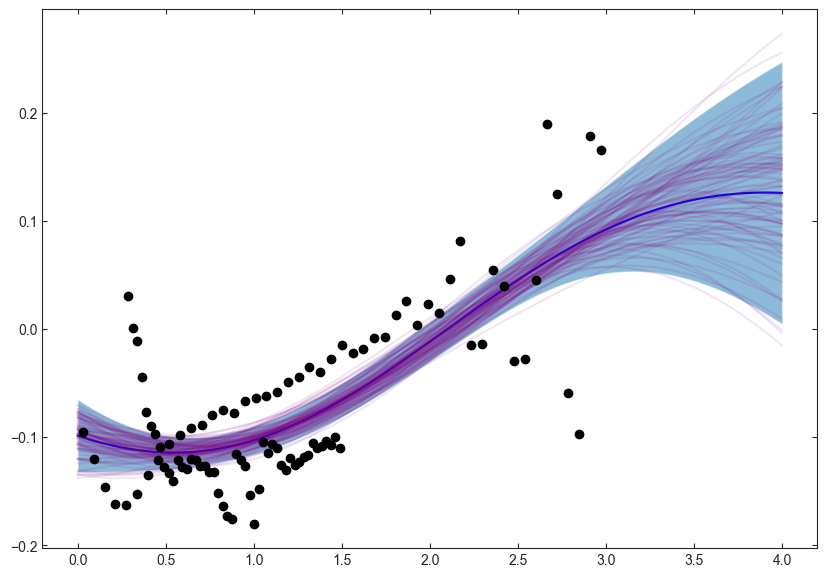

In [16]:
#train_dust2, train_dust_index, train_dust_index_errs = torch.from_numpy(bin_centers), torch.from_numpy(bin_means), torch.from_numpy(bin_std)

test_dust2 = torch.linspace(0, 4, 100)
#train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust_index, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

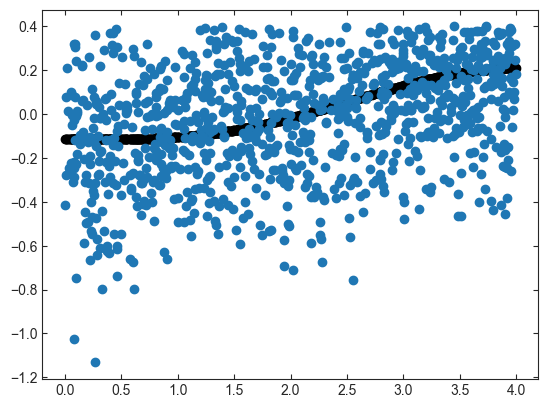

In [17]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
mean_dust_index = f_preds.sample().numpy()
scatter = np.random.uniform(0.1, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, scatter, -2.2, 0.4, len(test_tau)))

In [18]:
torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')

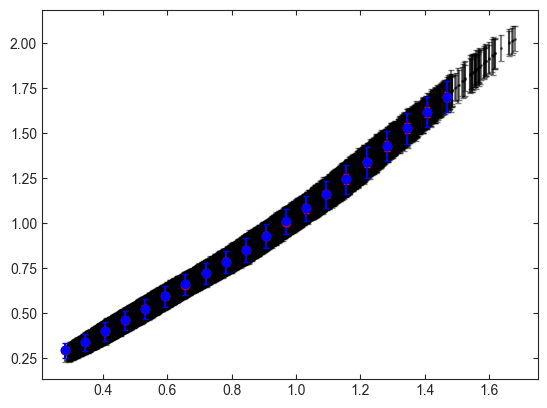

In [19]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, tau1, 0.0, 1.5, 25)
x, y, yerr = gpdp.process_samples_modified(tau, tau1, tau1e, 0.0, 1.5, 25)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

bin_centers_de, bin_means_de, bin_std_de = x, y, yerr


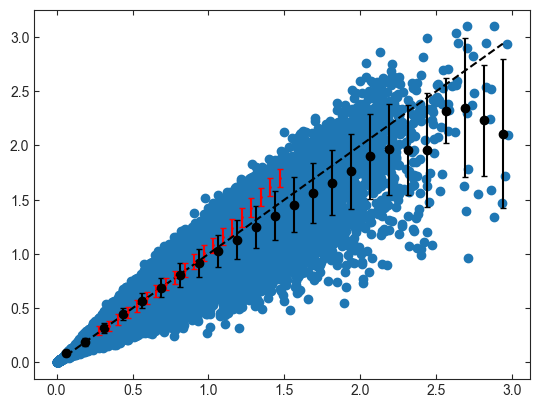

In [20]:
plt.scatter(dust2, dust1)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust1, 0.0, 3.0, 25)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')

195.1459639841031
180.18551410435228
165.13701328268266
150.09752899290478
135.17303274214925
120.4776229571599
106.13221662989227
92.26256402020557
78.99679690518117
66.46246923733425
54.78304778527457
44.073856771646156
34.43752275468486
25.95902107110197
18.700502294197126
12.696180463332185
7.947691841978721
4.4204694766619514
2.041793178878659
0.7012153395605251
0.2539665954531182
0.2105465009186425
0.16735456061724288
0.12434504326931602
0.08159234706084433
0.03917598301342635
-0.002819675232564706
-0.044305407077618854
-0.08518701674693022
-0.12536513782618056
-0.16473503721305424
-0.2031864791435307
-0.24060370764719344
-0.27686560678698796
-0.31184610177747446
-0.3454148697450947
-0.3774384353717263
-0.407781732403893
-0.4363102149197502
-0.46289259955139206
-0.4874043080023107
-0.5097316538416595
-0.5297767737918645
-0.547463236671545
-0.5627421690911146
-0.575598615244206
-0.5860577036619806
-0.5941900402759202
-0.6001156096253898
-0.6040053816410708
-0.6060798358740843
-0.6

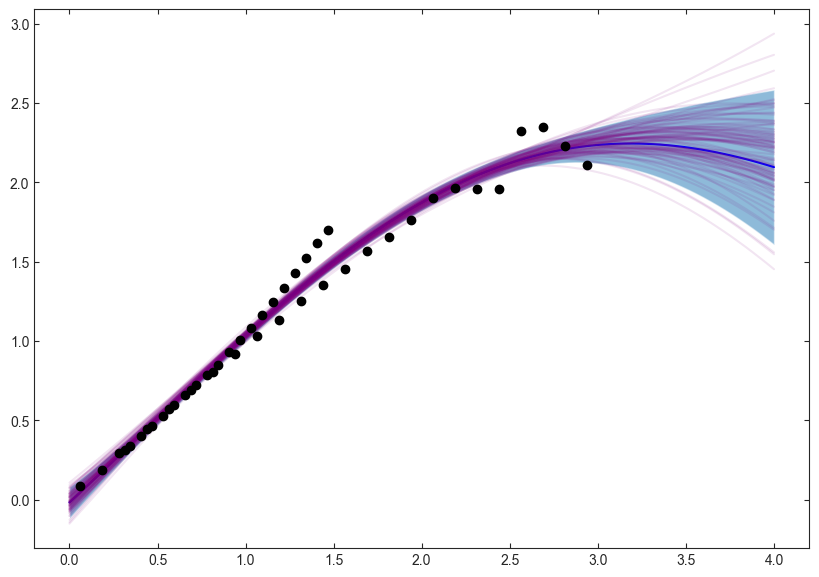

In [21]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust1, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

195.09891800190678
180.1358297452381
165.08429539561996
150.04146087302885
135.11352911295955
120.41478182181686
106.06617008192346
92.19342725380297
78.92466481215709
66.387422350889
54.70515882084822
43.99319612227436
34.3541626254777
25.873038208430092
18.61197932843252
12.605205863437993
7.8543584045039685
4.324871177461106
1.9440201508856283
0.6013467514177923
0.1520613275453062
0.10664558764157568
0.06146810422244577
0.01644408264740885
-0.02839928350098359
-0.0730384583997644
-0.11745405310952166
-0.1616305229729242
-0.20555498505575087
-0.24921522313476413
-0.29259715056773056
-0.3356821736044229
-0.37844494813746044
-0.42085190139852585
-0.46286062853973414
-0.5044199777766604
-0.5454704306555572
-0.5859443464089732
-0.6257657770800801
-0.6648498119909838
-0.7031016791506546
-0.7404160210228863
-0.776676808781988
-0.81175825142404
-0.845526837763239
-0.877844401694188
-0.9085719097382202
-0.9375735908603933
-0.9647210696863038
-0.989897289294997
-1.013000159833153
-1.033945988

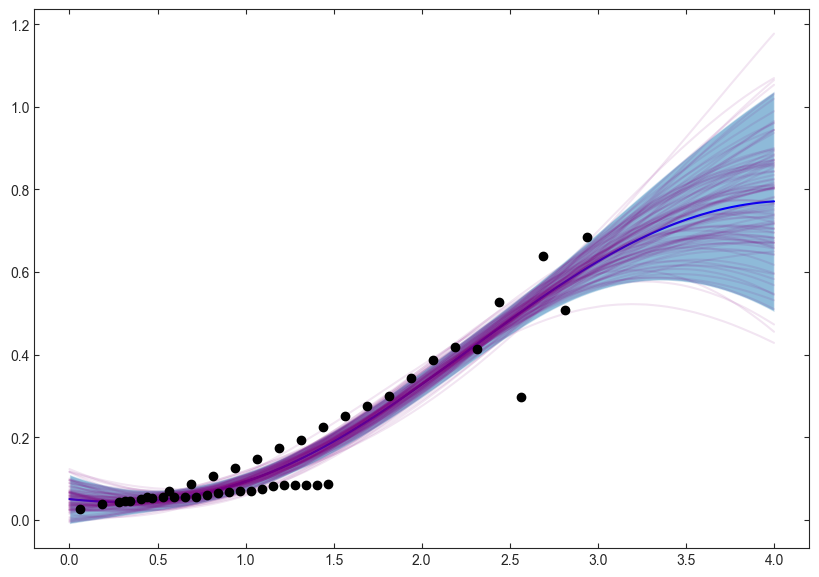

In [22]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model_noerr(train_dust2, train_dust1_errs, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model_sig, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1_errs, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

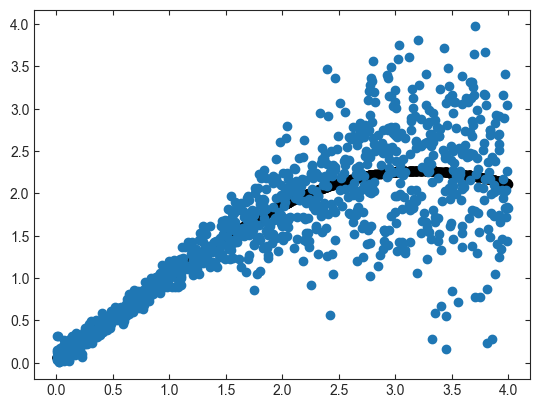

In [34]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_tau)
mean_dust1 = f_preds.sample().numpy()
sig_dust1 = f_preds_sig.sample().numpy()
sig_dust1 = np.where(sig_dust1<0.001, 0.001, sig_dust1)
#scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, sig_dust1, 0.0, 4.0, len(test_tau)))

In [24]:
torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')
torch.save(trained_model_sig.state_dict(), 'gp_models/dust1sig.pth')